The restricted three-body problem
===================

In this example, we will consider the restricted three-body problem (RTBP). The RTBP is a well-known dynamical system consisting of two massive bodies orbiting each other on circular Keplerian orbits, and a massless particle which moves under the gravitational influence of the two massive bodies.

The problem is usually formulated in a rotating reference frame in which the two massive bodies are at rest. In the rotating reference frame, the equations of motion for the massless particle's cartesian coordinates $\left(x, y, z\right)$ and conjugated momenta $\left(p_x, p_y, p_z\right)$ read:

$$
\begin{aligned}
\dot{x} & = p_x+y,\\
\dot{y} & = p_y-x, \\
\dot{z} & = p_z, \\
\dot{p}_x & = p_y - \frac{1-\mu}{r_{PS}^3}\left( x - \mu \right)-\frac{\mu}{r_{PJ}^3}\left( x - \mu + 1\right), \\
\dot{p}_y & = -p_x-\left( \frac{1-\mu}{r_{PS}^3} +  \frac{\mu}{r_{PJ}^3}\right)y, \\
\dot{p}_z & = -\left( \frac{1-\mu}{r_{PS}^3} +  \frac{\mu}{r_{PJ}^3}\right)z,
\end{aligned}
$$

where $\mu$ is a mass parameter, $r_{PS}^2=\left( x-\mu \right)^2+y^2+z^2$ and $r_{PJ}^2=\left( x -\mu + 1 \right)^2+y^2+z^2$. The Hamiltonian of the RTBP reads:

$$
\mathcal{H} = \frac{1}{2}\left( p_x^2+p_y^2+p_z^2 \right) +yp_x-xp_y-\frac{1-\mu}{r_{PS}}-\frac{\mu}{r_{PJ}}.
$$

Because $\mathcal{H}$ is not time-dependent, it is a conserved quantity, usually known as [Jacobi's integral](https://en.wikipedia.org/wiki/Jacobi_integral).

We will begin by integrating a RTBP with $\mu=0.01$ and a specific set of initial conditions which produces a stable quasi-periodic orbit. Let us define the equations of motion:

In [1]:
import heyoka as hy
import numpy as np

# Create the symbolic variables.
x, y, z, px, py, pz = hy.make_vars("x", "y", "z", "px", "py", "pz")

# Fix mu to 0.01.
mu = 0.01

rps_32 = ((x - mu) ** 2 + y**2 + z**2) ** (-3 / 2.0)
rpj_32 = ((x - mu + 1.0) ** 2 + y**2 + z**2) ** (-3 / 2.0)

# The equations of motion.
dxdt = px + y
dydt = py - x
dzdt = pz
dpxdt = py - (1.0 - mu) * rps_32 * (x - mu) - mu * rpj_32 * (x - mu + 1.0)
dpydt = -px - ((1.0 - mu) * rps_32 + mu * rpj_32) * y
dpzdt = -((1.0 - mu) * rps_32 + mu * rpj_32) * z

Next, we can create the integrator object:

In [2]:
ta = hy.taylor_adaptive(
    # The ODEs.
    [(x, dxdt), (y, dydt), (z, dzdt), (px, dpxdt), (py, dpydt), (pz, dpzdt)],
    # The initial conditions.
    [-0.45, 0.80, 0.00, -0.80, -0.45, 0.58],
    # Operate below machine precision
    # and in high-accuracy mode.
    tol=1e-18,
    high_accuracy=True,
)

Let us now integrate the RTBP up to $t=200$ time units:

In [3]:
t_grid = np.linspace(0, 200, 2500)

out = ta.propagate_grid(t_grid)
out

(<taylor_outcome.time_limit: -4294967299>,
 0.14525004089826876,
 0.4117835887806712,
 753,
 None,
 array([[-0.45      ,  0.8       ,  0.        , -0.8       , -0.45      ,
          0.58      ],
        [-0.44964278,  0.79928721,  0.04635564, -0.79085155, -0.46766159,
          0.57764241],
        [-0.44873221,  0.79709232,  0.09233488, -0.78330782, -0.48565007,
          0.57060575],
        ...,
        [-0.53277542,  0.55791842, -0.41830177, -0.86253076, -0.63134777,
          0.29132422],
        [-0.55694917,  0.55116291, -0.39307634, -0.84974288, -0.62735539,
          0.33859758],
        [-0.58042685,  0.54661332, -0.36418594, -0.83390023, -0.62399926,
          0.38281904]]))

We are now ready to plot the trajectory of the massless particle:

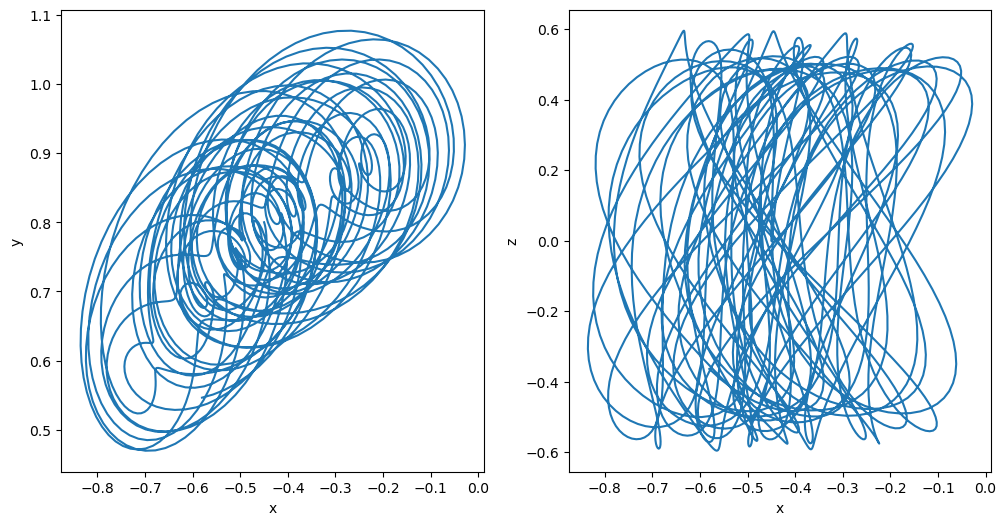

In [4]:
from matplotlib.pylab import plt

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(out[5][:, 0], out[5][:, 1])
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
plt.plot(out[5][:, 0], out[5][:, 2])
plt.xlabel("x")
plt.ylabel("z");

The left panel displays a top-down view of the trajectory, while the right panel shows a side view. As anticipated earlier, the set of initial conditions we chose produces a regular, quasi-periodic trajectory which stays away from the two centres of force (which are located at $x=0.01$ and $x=-0.99$).

Let us now check how well Jacobi's integral is conserved. First, we define a function for the computation of the value of the Hamiltonian for a given input state vector:

In [5]:
def ham(s):
    x, y, z, px, py, pz = s

    rps = ((x - mu) ** 2 + y**2 + z**2) ** 0.5
    rpj = ((x - mu + 1.0) ** 2 + y**2 + z**2) ** 0.5

    return 0.5 * (px**2 + py**2 + pz**2) + y * px - x * py - (1 - mu) / rps - mu / rpj

Next, we plot the relative error of Jacobi's integral throughout the integration with respect to its initial value:

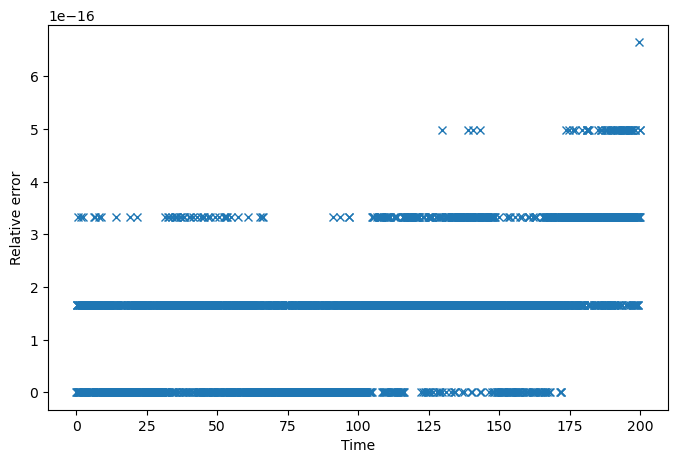

In [6]:
fig = plt.figure(figsize=(8, 5))

plt.plot(t_grid, abs((ham(out[5][0]) - ham(out[5].transpose())) / ham(out[5][0])), "x")
plt.xlabel("Time")
plt.ylabel("Relative error");

We can see how, for this short-term integration, Jacobi's integral is preserved roughly at machine precision.

Let us now reset the initial state of the system to another set of initial conditions:

In [7]:
ta.time = 0
ta.state[:] = [-0.80, 0.0, 0.0, 0.0, -0.6276410653920693, 0.0]

This new set of initial conditions has been chosen to generate a planar orbit featuring close encounters with both massive bodies. Let us integrate this new orbit up to $t = 2000$ time units:

In [8]:
t_grid = np.linspace(0, 2000, 100000)

out = ta.propagate_grid(t_grid)
out

(<taylor_outcome.time_limit: -4294967299>,
 0.0003689101085023595,
 0.23936494270073383,
 28829,
 None,
 array([[-0.8       ,  0.        ,  0.        ,  0.        , -0.62764107,
          0.        ],
        [-0.79984466,  0.00344461,  0.        ,  0.0120914 , -0.62787633,
          0.        ],
        [-0.79937842,  0.0068736 ,  0.        ,  0.02421839, -0.62858128,
          0.        ],
        ...,
        [-0.28606638, -0.38317725,  0.        ,  1.45700845, -0.45768591,
          0.        ],
        [-0.26419973, -0.38643491,  0.        ,  1.49934284, -0.41776562,
          0.        ],
        [-0.24154658, -0.3892956 ,  0.        ,  1.54173429, -0.37340628,
          0.        ]]))

We can now take a look at the integrated orbit:

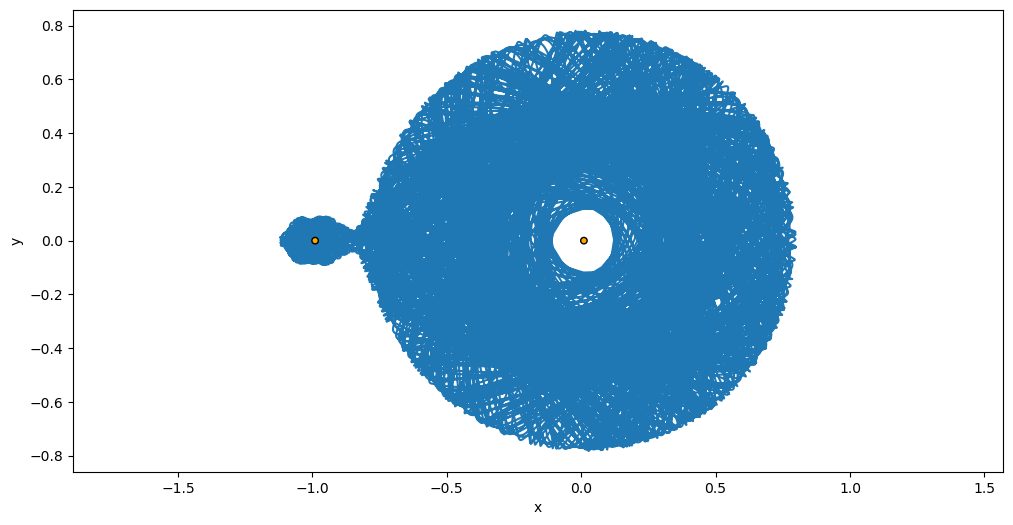

In [9]:
fig = plt.figure(figsize=(12, 6))

ax = plt.subplot(1, 1, 1)

plt.axis("equal")
plt.plot(out[5][:, 0], out[5][:, 1])

cc0 = plt.Circle((0.01, 0.0), 0.012, ec="black", fc="orange", zorder=2)
cc1 = plt.Circle((-0.99, 0.0), 0.012, ec="black", fc="orange", zorder=2)

ax.add_artist(cc0)
ax.add_artist(cc1)

plt.xlabel("x")
plt.ylabel("y");

We can see how the massless particle now explores regions surrounding both massive particles. The motion is bounded by the zero velocity curve, which is implicitly defined by Jacobi's integral after imposing the constraint that the square of the velocity of the massless particle cannot be negative.

Let us now take a look at the conservation of Jacobi's integral in this trajectory:

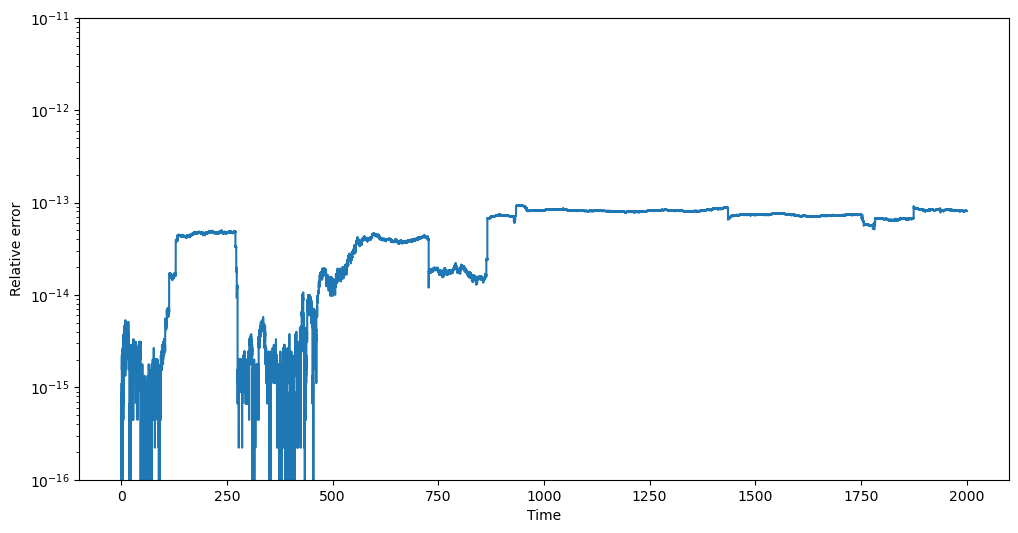

In [11]:
fig = plt.figure(figsize=(12, 6))

plt.semilogy(t_grid, abs((ham(out[5][0]) - ham(out[5].transpose()))))
plt.ylim(1e-16, 1e-11)
plt.xlabel("Time")
plt.ylabel("Relative error");

The relative error on Jacobi's integral remains around $10^{-13}$.